In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


Load and Preprocess the Images

In [ ]:
# Set the path to your dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset"  # Adjust this path based on your dataset location in Google Colab
categories = ["yes", "no"]  # Folders containing tumor (yes) and normal (no) MRI images
img_size = 224

# Function to load and preprocess images
def load_data(data_path, categories, img_size):
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_path, category)
        class_label = categories.index(category)  # 0 for 'no', 1 for 'yes'

        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read image
                img = cv2.resize(img, (img_size, img_size))  # Resize image
                img = img / 255.0  # Normalize pixel values between 0 and 1
                data.append(img)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    return np.array(data), np.array(labels)

# Load the data
data, labels = load_data(data_path, categories, img_size)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


Data shape: (253, 224, 224, 3), Labels shape: (253,)


Augmentation

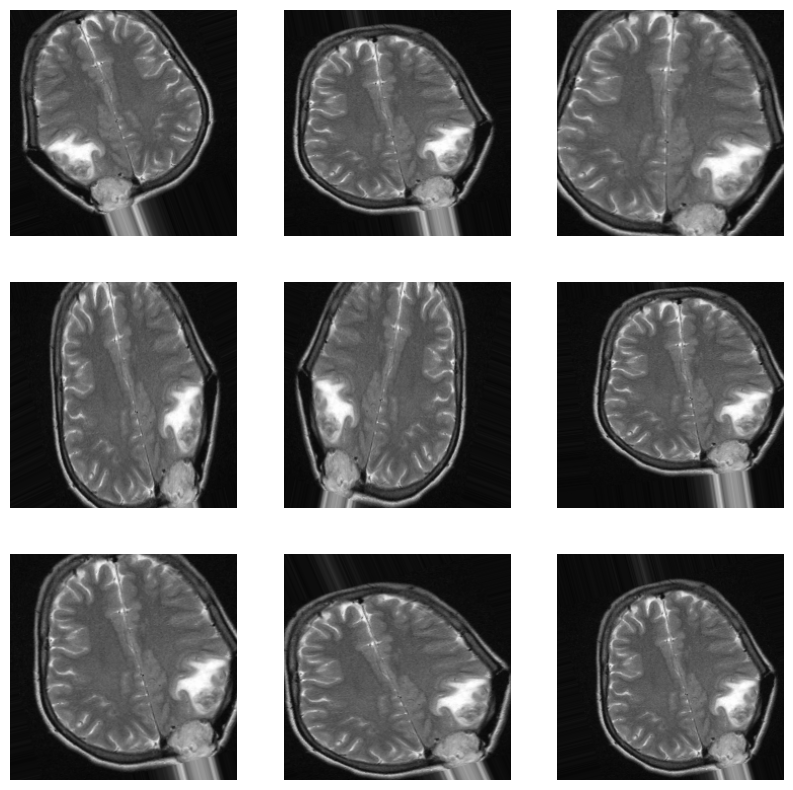

In [ ]:
# Augmentation using ImageDataGenerator
data_gen = ImageDataGenerator(
    rotation_range=20,     # Randomly rotate images
    width_shift_range=0.1, # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    shear_range=0.1,       # Shear angle in counter-clockwise direction
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill in missing pixels with nearest neighbors
)

# Example of augmenting a sample
# Let's visualize one augmented example from the dataset
sample_idx = 0
sample_image = data[sample_idx].reshape((1, img_size, img_size, 3))  # Sample image for augmentation

plt.figure(figsize=(10, 10))
for i in range(9):
    aug_img = next(data_gen.flow(sample_image, batch_size=1))[0] # Use next() with the iterator as an argument
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.axis('off')
plt.show()

Train-Test Split

In [ ]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training data shape: (202, 224, 224, 3), Training labels shape: (202,)
Testing data shape: (51, 224, 224, 3), Testing labels shape: (51,)


Implement the CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create the CNN model
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the convolutional layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,                 # You can increase the number of epochs if needed
    validation_split=0.2,      # Use 20% of the training data for validation
    batch_size=32,             # Adjust batch size if necessary
    verbose=1
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6396 - loss: 0.9224 - val_accuracy: 0.7317 - val_loss: 0.5453
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8200 - loss: 0.4572 - val_accuracy: 0.7561 - val_loss: 0.5320
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7876 - loss: 0.4562 - val_accuracy: 0.7805 - val_loss: 0.5368
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8245 - loss: 0.4658 - val_accuracy: 0.8049 - val_loss: 0.5395
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8420 - loss: 0.4814 - val_accuracy: 0.7561 - val_loss: 0.5689
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8359 - loss: 0.4605 - val_accuracy: 0.8293 - val_loss: 0.5200
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8254 - loss: 0.3922 - val_accuracy: 0.8293 - val_loss: 0.5073
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8149 - loss: 0.3614 - val_accuracy: 0.8293 - val_loss: 0.4980
Epoch 9/

 Evaluate the Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - accuracy: 0.8564 - loss: 1.0054
Test Accuracy: 86.27%


 Plot Training History

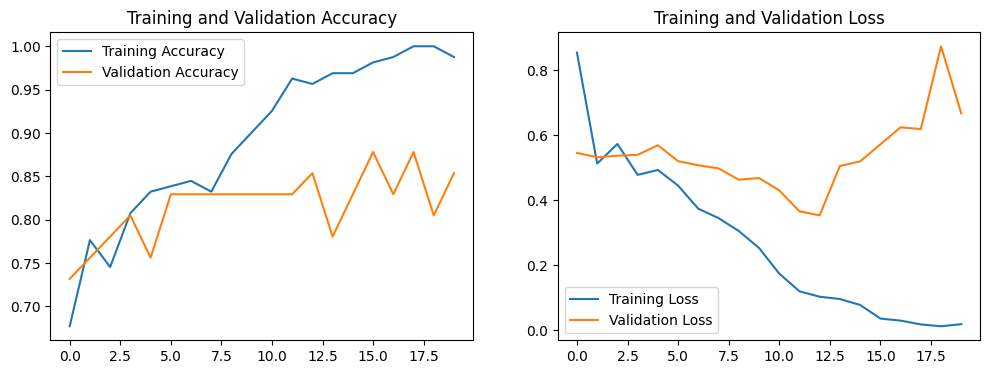

In [ ]:
# Plot the training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


Confusion Matrix and Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


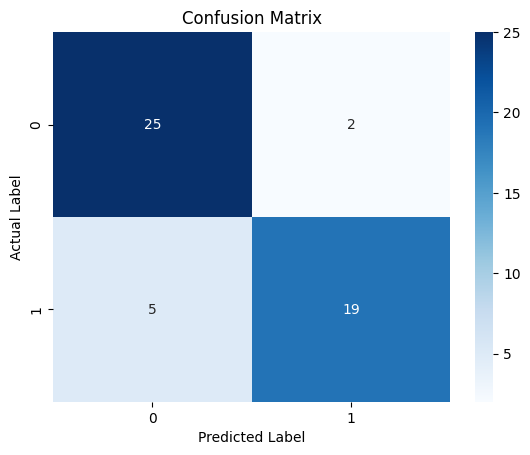

              precision    recall  f1-score   support

    No Tumor       0.83      0.93      0.88        27
       Tumor       0.90      0.79      0.84        24

    accuracy                           0.86        51
   macro avg       0.87      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["No Tumor", "Tumor"]))


In [ ]:
# Save the model
model.save('brain_tumor_detection_model.h5')
print("Model saved!")


Model saved!
